In [1]:
from PIL import Image
import numpy as np
import cv2
import seaborn as sns
import matplotlib.patches as patches
import pandas as pd
from typing import NamedTuple

In [2]:
i = Image.open("save.png")

In [3]:
binary = cv2.threshold(np.asarray(i), 70, 255,cv2.THRESH_BINARY)[1]

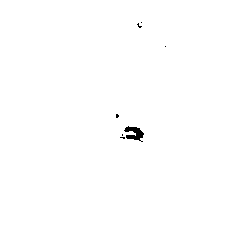

In [4]:
Image.fromarray(binary)

In [5]:
def group_starts(a):
    if len(a) == 1:
        return np.array([0,1])
    shifted = np.array(list(zip(a[-len(a):], a[-len(a)+1:])))
    res = np.array([i for i in map(lambda x: x[1] in (x[0], x[0]+1), shifted)])
    # rest is based on https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065
    cuts = np.empty(len(res), dtype=bool)
    cuts[0] = True
    np.not_equal(res[:-1], res[1:], out=cuts[1:])
    starts = np.nonzero(cuts)[0]
    return np.append(starts, None)

In [6]:
# rects are in form:
# tlx, tly, brx, bry
class Overlap(NamedTuple):
    overlapping: bool
    tlx: int
    tly: int
    brx: int
    bry: int
def rect_overlap(r1, r2) -> Overlap:
    merged_tlx = max(r1[0], r2[0])
    merged_tly = max(r1[1], r2[1])
    merged_brx = min(r1[2], r2[2])
    merged_bry = min(r1[3], r2[3])

    if merged_tlx > merged_brx or merged_tly > merged_bry:
        overlap = False
    else:
        overlap = True
    
    return Overlap(
        overlapping=overlap,
        tlx=merged_tlx,
        tly=merged_tly,
        brx=merged_brx,
        bry=merged_bry
    )


In [7]:
ret = np.argwhere(binary == 0)
print("{")
for p in ret:
    print(f"    Point({p[1]}, {p[0]}).")
print("}")

{
    Point(141, 22).
    Point(138, 23).
    Point(137, 24).
    Point(138, 24).
    Point(138, 25).
    Point(138, 26).
    Point(139, 26).
    Point(140, 26).
    Point(141, 26).
    Point(139, 27).
    Point(140, 27).
    Point(165, 46).
    Point(116, 114).
    Point(117, 114).
    Point(116, 115).
    Point(117, 115).
    Point(118, 115).
    Point(116, 116).
    Point(117, 116).
    Point(118, 116).
    Point(116, 117).
    Point(117, 117).
    Point(128, 126).
    Point(126, 127).
    Point(127, 127).
    Point(128, 127).
    Point(129, 127).
    Point(130, 127).
    Point(131, 127).
    Point(132, 127).
    Point(133, 127).
    Point(134, 127).
    Point(135, 127).
    Point(136, 127).
    Point(125, 128).
    Point(126, 128).
    Point(127, 128).
    Point(128, 128).
    Point(129, 128).
    Point(130, 128).
    Point(131, 128).
    Point(132, 128).
    Point(133, 128).
    Point(134, 128).
    Point(135, 128).
    Point(136, 128).
    Point(137, 128).
    Point(138, 128).
  

In [8]:
ret = np.argwhere(binary == 0)
ret = np.array(sorted(list(map(tuple, ret)), key=lambda x:x[0]))
y = np.squeeze(np.hsplit(ret, 2)[0])
x = np.squeeze(np.hsplit(ret, 2)[1])

In [9]:
box_points = []
y_starts = group_starts(y)
ys_prev = 0
for ys in y_starts:
    g = sorted(x[ys_prev:ys])
    if not len(g):
        continue
    miny = min(y[ys_prev:ys])
    maxy = max(y[ys_prev:ys])
    if ys is not None:
        ys_prev = ys+1
    x_starts = group_starts(g)
    xs_prev = 0
    for xs in x_starts:
        gsub = g[xs_prev:xs]
        if not len(gsub):
            continue
        minx = min(gsub)
        maxx = max(gsub)
        box_points.append((minx, miny, maxx, maxy))
        if xs is not None:
            xs_prev = xs+1

In [10]:
ybox_df = pd.DataFrame(box_points, columns=("minx", "miny", "maxx", "maxy"))
ybox_df

,minx,miny,maxx,maxy
0,137,22,141,27
1,165,46,165,46
2,116,114,118,117
3,120,126,143,141


In [11]:
ret = np.argwhere(binary == 0)
ret = np.array(sorted(list(map(tuple, ret)), key=lambda x:x[1]))
y = np.squeeze(np.hsplit(ret, 2)[0])
x = np.squeeze(np.hsplit(ret, 2)[1])

In [12]:
box_points = []
x_starts = group_starts(x)
xs_prev = 0
for xs in x_starts:
    g = sorted(y[xs_prev:xs])
    if not len(g):
        continue
    minx = min(x[xs_prev:xs])
    maxx = max(x[xs_prev:xs])
    if xs is not None:
        xs_prev = xs+1
    y_starts = group_starts(g)
    ys_prev = 0
    for ys in y_starts:
        gsub = g[ys_prev:ys]
        if not len(gsub):
            continue
        miny = min(gsub)
        maxy = max(gsub)
        box_points.append((minx, miny, maxx, maxy))
        if ys is not None:
            ys_prev = ys+1

In [13]:
xbox_df = pd.DataFrame(box_points, columns=("minx", "miny", "maxx", "maxy"))
xbox_df

,minx,miny,maxx,maxy
0,116,114,118,117
1,120,22,143,27
2,120,126,143,141
3,165,46,165,46


In [14]:
overlaps = []
for (i,r1) in xbox_df.iterrows():
    for (i,r2) in ybox_df.iterrows():
        ov = rect_overlap(
            (r1['minx'], r1['miny'], r1['maxx'], r1['maxy']),
            (r2['minx'], r2['miny'], r2['maxx'], r2['maxy'])
        )
        if ov.overlapping:
            print(ov)
            overlaps.append(ov)

Overlap(overlapping=True, tlx=116, tly=114, brx=118, bry=117)
Overlap(overlapping=True, tlx=137, tly=22, brx=141, bry=27)
Overlap(overlapping=True, tlx=120, tly=126, brx=143, bry=141)
Overlap(overlapping=True, tlx=165, tly=46, brx=165, bry=46)


In [15]:
splits = np.squeeze(np.hsplit(np.array(ret), 2))
points = pd.DataFrame({'y': splits[0], 'x': splits[1]})

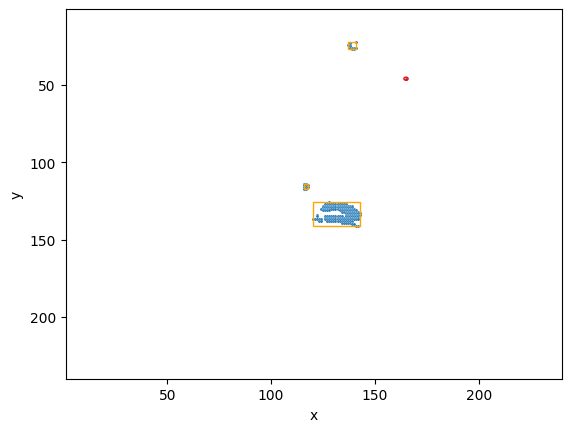

In [16]:

ax = sns.scatterplot(points, y='y', x='x', s=5)
ax.invert_yaxis()
ax.set_xlim(1, 240)
ax.set_ylim(240, 1)

# for (i,r) in xbox_df.iterrows():
#     if r['minx'] == r['maxx'] and r['miny'] == r['maxy']:
#         mypatch = patches.Circle((r['minx'], r['miny']), radius=1)
#         mypatch.set(color='red', fill=False)
#     else:
#         base_point = (r['minx'], r['miny'])
#         width = r['maxx'] - r['minx']
#         height = r['maxy'] - r['miny']
#         mypatch = patches.Rectangle(base_point, width, height)
#         mypatch.set(color='red', fill=False)
#     ax.add_patch(mypatch)

# for (i,r) in ybox_df.iterrows():
#     if r['minx'] == r['maxx'] and r['miny'] == r['maxy']:
#         mypatch = patches.Circle((r['minx'], r['miny']), radius=1)
#         mypatch.set(color='green', fill=False)
#     else:
#         base_point = (r['minx'], r['miny'])
#         width = r['maxx'] - r['minx']
#         height = r['maxy'] - r['miny']
#         mypatch = patches.Rectangle(base_point, width, height)
#         mypatch.set(color='green', fill=False)
#     ax.add_patch(mypatch)

for mr in overlaps:
    if mr.tlx == mr.brx and mr.tly == mr.bry:
        mypatch = patches.Circle((mr.tlx, mr.tly), radius=1)
        mypatch.set(color='red', fill=False)
    else:
        base_point = (mr.tlx, mr.tly)
        width = mr.brx - mr.tlx
        height = mr.bry - mr.tly
        mypatch = patches.Rectangle(base_point, width, height)
        mypatch.set(color='orange', fill=False)
    ax.add_patch(mypatch)


In [17]:
from sklearn.cluster import KMeans
model = KMeans(min(max(len(ret), 1), 5), n_init='auto', random_state=3).fit(ret)
model.cluster_centers_

array([[129.29166667, 135.        ],
       [ 26.83333333, 141.16666667],
       [133.13114754, 127.14754098],
       [115.5       , 116.8       ],
       [135.84285714, 138.        ]])

# TODO
while scanning, each time we enter a dark area, extend a bounding
box.  Extend one row past the current row.  On teh subsequent
rows test if we are in one of the boxes and extend it if we are

In [18]:
ret.astype(np.float32)
import cv2 as cv
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_RANDOM_CENTERS
compactness,labels,centers = cv.kmeans(ret.astype(np.float32),min(max(len(ret), 1), 5),None,criteria,10,flags)
ret = centers
ret

array([[135.52779 , 138.22223 ],
       [ 26.833334, 141.16667 ],
       [115.5     , 116.8     ],
       [128.92453 , 133.62265 ],
       [134.16667 , 127.07407 ]], dtype=float32)